In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import os
import time

# Import PyTorch libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

print("Libraries imported - ready to use PyTorch", torch.__version__)

def show_image(image, label):
    image = image.permute(1, 2, 0)
    plt.imshow(image.squeeze())
    plt.title(f'Label: {label}')
    plt.show()

Libraries imported - ready to use PyTorch 2.1.0


In [19]:
# device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

# device="cpu"

print(f"Using {device} device")

# resume training options
resume_training = True

class Params:
    def __init__(self):
        self.batch_size = 16
        self.name = "resnet_152_sgd1"
        self.workers = 4
        self.lr = 0.1
        self.momentum = 0.9
        self.weight_decay = 1e-4
        self.lr_step_size = 30
        self.lr_gamma = 0.1

    def __repr__(self):
        return str(self.__dict__)

    def __eq__(self, other):
        return self.__dict__ == other.__dict__

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
params = Params()
params, params.batch_size

Using mps device


({'batch_size': 16, 'name': 'resnet_152_sgd1', 'workers': 4, 'lr': 0.1, 'momentum': 0.9, 'weight_decay': 0.0001, 'lr_step_size': 30, 'lr_gamma': 0.1},
 16)

In [3]:
training_folder_name = '../imagenet/ILSVRC/Data/CLS-LOC/train'
val_folder_name = '../imagenet/ILSVRC/Data/CLS-LOC/val'

In [4]:
os.listdir(training_folder_name)

['n02795169',
 'n02422699',
 'n02769748',
 'n02319095',
 'n02111500',
 'n02834397',
 'n02917067',
 'n02808304',
 'n02514041',
 'n02058221',
 'n02793495',
 'n02814533',
 'n02497673',
 'n02095314',
 'n02100877',
 'n02837789',
 'n02105162',
 'n02037110',
 'n02643566',
 'n02088238',
 'n02840245',
 'n02127052',
 'n02124075',
 'n02504013',
 'n02317335',
 'n02089973',
 'n02108422',
 'n02085782',
 'n02104029',
 'n02992211',
 'n02397096',
 'n02094258',
 'n02009229',
 'n02088094',
 'n02480495',
 'n02093428',
 'n02444819',
 'n02134418',
 'n02480855',
 'n02097474',
 'n02701002',
 'n02006656',
 'n02106382',
 'n02870880',
 'n02093647',
 'n02138441',
 'n02088466',
 'n02804414',
 'n02077923',
 'n02107574',
 'n02909870',
 'n02910353',
 'n02977058',
 'n02859443',
 'n02114367',
 'n02950826',
 'n02086646',
 'n02268853',
 '.DS_Store',
 'n02804610',
 'n02443114',
 'n02279972',
 'sample.tar',
 'n02483362',
 'n02408429',
 'n02086240',
 'n02484975',
 'n02403003',
 'n02483708',
 'n02786058',
 'n02113978',
 'n02

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([16, 3, 224, 224])


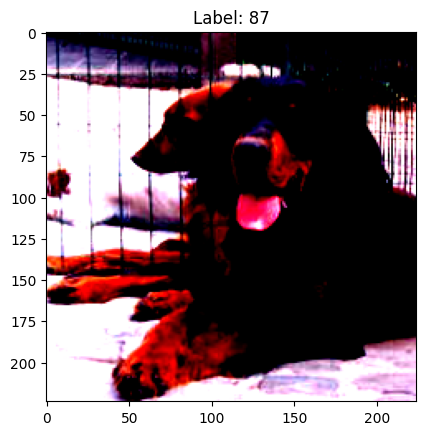

In [5]:
train_transformation = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomResizedCrop(224, interpolation=transforms.InterpolationMode.BILINEAR, antialias=True),
        transforms.RandomHorizontalFlip(0.5),
        # Normalize the pixel values (in R, G, and B channels)
        transforms.Normalize(mean=[0.485, 0.485, 0.406], std=[0.229, 0.224, 0.225])
    ])

train_dataset = torchvision.datasets.ImageFolder(
    root=training_folder_name,
    transform=train_transformation
)
train_sampler = torch.utils.data.RandomSampler(train_dataset)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=params.batch_size,
    sampler=train_sampler,
    num_workers = params.workers,
    pin_memory=True,
)
for X, y in train_loader:
    break
print(X.shape)
show_image(X[0], y[0])

In [6]:
train_dataset[1337]

(tensor([[[-0.2684, -0.2667, -0.2542,  ..., -0.2213, -0.2025, -0.1999],
          [-0.2684, -0.2667, -0.2542,  ..., -0.2213, -0.2025, -0.1999],
          [-0.2684, -0.2667, -0.2542,  ..., -0.2213, -0.2025, -0.1999],
          ...,
          [-0.1299, -0.1233, -0.0743,  ...,  0.6540,  0.6191,  0.6144],
          [-0.1143, -0.1093, -0.0716,  ...,  0.4724,  0.5289,  0.5364],
          [-0.1143, -0.1093, -0.0716,  ...,  0.4724,  0.5289,  0.5364]],
 
         [[-0.0118, -0.0092,  0.0100,  ...,  0.0364,  0.0556,  0.0582],
          [-0.0118, -0.0092,  0.0100,  ...,  0.0364,  0.0556,  0.0582],
          [-0.0118, -0.0092,  0.0100,  ...,  0.0364,  0.0556,  0.0582],
          ...,
          [-0.0065, -0.0086, -0.0245,  ..., -1.0201, -0.9831, -0.9781],
          [-0.0118, -0.0153, -0.0409,  ..., -1.2558, -1.1469, -1.1323],
          [-0.0118, -0.0153, -0.0409,  ..., -1.2558, -1.1469, -1.1323]],
 
         [[ 0.7402,  0.7428,  0.7619,  ...,  0.7185,  0.7377,  0.7402],
          [ 0.7402,  0.7428,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 3, 224, 224])


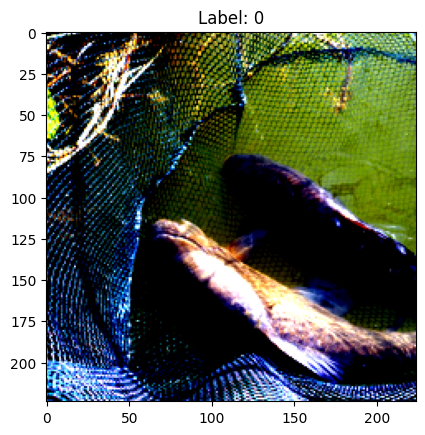

In [7]:
val_transformation = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(size=256, antialias=True),
        transforms.CenterCrop(224),
        # Normalize the pixel values (in R, G, and B channels)
        transforms.Normalize(mean=[0.485, 0.485, 0.406], std=[0.229, 0.224, 0.225])
    ])
val_dataset = torchvision.datasets.ImageFolder(
    root=val_folder_name,
    transform=val_transformation
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=64,
    num_workers=params.workers,
    shuffle=False,
    pin_memory=True
)
for X, y in val_loader:
    break
print(X.shape)
show_image(X[0], y[0])

In [8]:
from math import sqrt
def train(dataloader, model, loss_fn, optimizer, epoch, writer):
    size = len(dataloader.dataset)
    model.train()
    start0 = time.time()
    start = time.time()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        batch_size = len(X)
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * batch_size
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}], {(current/size * 100):>4f}%")
            step = epoch * size + current
            writer.add_scalar('training loss',
                            loss,
                            step)
            new_start = time.time()
            delta = new_start - start
            start = new_start
            if batch != 0:
                print("Done in ", delta, " seconds")
                remaining_steps = size - current
                speed = 100 * batch_size / delta
                remaining_time = remaining_steps / speed
                print("Remaining time (seconds): ", remaining_time)
        optimizer.zero_grad()
    print("Entire epoch done in ", time.time() - start0, " seconds")

In [9]:
def test(dataloader, model, loss_fn, epoch, writer, train_dataloader, calc_acc5=False):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct, correct_top5 = 0, 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            if calc_acc5:
                _, pred_top5 = pred.topk(5, 1, largest=True, sorted=True)
                correct_top5 += pred_top5.eq(y.view(-1, 1).expand_as(pred_top5)).sum().item()
    test_loss /= num_batches
    step = epoch * len(train_dataloader.dataset)
    if writer != None:
        writer.add_scalar('test loss',
                            test_loss,
                            step)
    correct /= size
    correct_top5 /= size
    if writer != None:
        writer.add_scalar('test accuracy',
                            100*correct,
                            step)
        if calc_acc5:
            writer.add_scalar('test accuracy5',
                            100*correct_top5,
                            step)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    if calc_acc5:
        print(f"Test Error: \n Accuracy-5: {(100*correct_top5):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [10]:
## testing a pretrained model to validate correctness of our dataset, transform and metrics code
pretrained_model = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT').to(device)
start = time.time()
loss_fn = nn.CrossEntropyLoss()
test(val_loader, pretrained_model, loss_fn, epoch=0, writer=None, train_dataloader=train_loader, calc_acc5=True)
print("Elapsed: ", time.time() - start)

Test Error: 
 Accuracy: 69.5%, Avg loss: 1.254691 

Test Error: 
 Accuracy-5: 88.9%, Avg loss: 1.254691 

Elapsed:  315.5984969139099


In [11]:
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=1,
        groups=groups,
        bias=False,
    )


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

In [12]:
from functools import partial
from typing import Any, Callable, List, Optional, Type, Union
from torch import Tensor
class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition" https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        base_width: int = 64,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0))
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [13]:
class ResNet(nn.Module):
    def __init__(
        self,
        block: Type[Bottleneck],
        layers: List[int],
        num_classes: int = 1000,
        width_per_group: int = 64,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(
        self,
        block: Type[Union[Bottleneck]],
        planes: int,
        blocks: int,
        stride: int = 1,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.base_width, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    base_width=self.base_width,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

In [14]:
device = "mps"
model = ResNet(Bottleneck, [3, 8, 36, 3]).to(device)
preds = model(X.to(device))
preds.shape

torch.Size([64, 1000])

In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), 
                            lr=params.lr, momentum=params.momentum, weight_decay=params.weight_decay)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=params.lr_step_size, gamma=params.lr_gamma)

In [20]:
start_epoch = 0
checkpoint_path = os.path.join("checkpoints", params.name, f"checkpoint.pth")
if resume_training and os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint["model"])
    start_epoch = checkpoint["epoch"] + 1
    optimizer.load_state_dict(checkpoint["optimizer"])
    lr_scheduler.load_state_dict(checkpoint["lr_scheduler"])
    assert params == checkpoint["params"]

In [25]:
from torch.utils.tensorboard import SummaryWriter
from pathlib import Path
Path(os.path.join("checkpoints", params.name)).mkdir(parents=True, exist_ok=True)
writer = SummaryWriter('runs/' + params.name)
test(val_loader, model, loss_fn, epoch=0, writer=writer, train_dataloader=train_loader, calc_acc5=True)
for epoch in range(start_epoch, 100):
    train(train_loader, model, loss_fn, optimizer, epoch=epoch, writer=writer)
    checkpoint = {
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "lr_scheduler": lr_scheduler.state_dict(),
        "epoch": epoch,
        "params": params
    }
    torch.save(checkpoint, os.path.join("checkpoints", params.name, f"model_{epoch}.pth"))
    torch.save(checkpoint, os.path.join("checkpoints", params.name, f"checkpoint.pth"))
    lr_scheduler.step()
    test(val_loader, model, loss_fn, epoch + 1, writer, train_dataloader=train_loader, calc_acc5=True)

Test Error: 
 Accuracy: 0.1%, Avg loss: 8.566721 

Test Error: 
 Accuracy-5: 0.5%, Avg loss: 8.566721 

loss: 5.389088  [   16/498723], 0.003208%
loss: 5.562056  [ 1616/498723], 0.324028%
Done in  78.63023376464844  seconds
Remaining time (seconds):  24429.774760026932
loss: 5.834253  [ 3216/498723], 0.644847%
Done in  84.197026014328  seconds
Remaining time (seconds):  26075.134855801014
loss: 5.845208  [ 4816/498723], 0.965666%
Done in  79.6962080001831  seconds
Remaining time (seconds):  24601.571877966522
loss: 5.915287  [ 6416/498723], 1.286486%
Done in  78.99250197410583  seconds
Remaining time (seconds):  24305.351043353825
loss: 5.618676  [ 8016/498723], 1.607305%
Done in  81.67512106895447  seconds
Remaining time (seconds):  25049.09602148965


RuntimeError: MPS backend out of memory (MPS allocated: 14.21 GB, other allocations: 3.93 GB, max allowed: 18.13 GB). Tried to allocate 8.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).